# VGGFace Architecture
VGGFace sample. 

```
pip install keras-vggface
```

We initially use MTCNN to identify and crop the actual face from an image. Check this is setup as described in the architecture-MTCNN notebook.


In [1]:
!pip show keras-vggface

Name: keras-vggface
Version: 0.5
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: c:\applications\miniconda3\envs\tensorflow-gpu\lib\site-packages
Requires: numpy, h5py, keras, tensorflow, pillow, six, pyyaml, scipy
Required-by: 


## Face Recognition
FInd a match for a given face.

In [3]:
# confirm mtcnn was installed correctly
import keras_vggface
# print version
print(keras_vggface.__version__)

0.5


In [4]:
# example of creating a face embedding
from keras_vggface.vggface import VGGFace
# create a vggface2 model
model = VGGFace(model='resnet50')
# summarize input and output shape
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

W0708 17:34:15.122449 12252 deprecation_wrapper.py:119] From C:\Applications\Miniconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 17:34:15.141449 12252 deprecation_wrapper.py:119] From C:\Applications\Miniconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 17:34:15.143448 12252 deprecation_wrapper.py:119] From C:\Applications\Miniconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 17:34:15.162481 12252 deprecation_wrapper.py:119] From C:\Applications\Miniconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v

165445632/165439116 [==============================] - 71s 0us/step
Inputs: [<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>]
Outputs: [<tf.Tensor 'classifier/Softmax:0' shape=(?, 8631) dtype=float32>]


We can see that the model expects input color images of faces with the shape of 244×244 and the output will be a class prediction of 8,631 people. This makes sense given that the pre-trained models were trained on 8,631 identities in the MS-Celeb-1M dataset.

In [15]:
# Example of face detection with a vggface2 model
import cv2
from cv2 import imread
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

# extract a single face from a given photograph using MTCNN
def extract_face(pixels, required_size=(224, 224)):
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

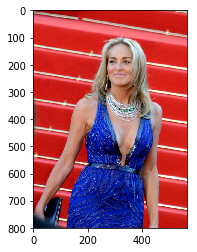

In [16]:
# load the photo and extract the face
image = cv2.imread('sharon_stone1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pyplot.imshow(image)

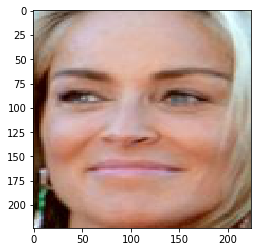

In [17]:
# extract the face
pixels = extract_face(image)
pyplot.imshow(pixels)

In [18]:
# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)

# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)

# create a vggface model
model = VGGFace(model='resnet50')

# perform prediction
yhat = model.predict(samples)

# convert prediction into names
results = decode_predictions(yhat)

# display most likely results
for result in results[0]:
    print('%s: %.3f%%' % (result[0], result[1]*100))

b' Sharon_Stone': 99.643%
b' Noelle_Reno': 0.085%
b' Elisabeth_R\xc3\xb6hm': 0.033%
b' Anita_Lipnicka': 0.026%
b' Tina_Maze': 0.019%


## Face Identification
See if a face matches a reference image.

In [21]:
# face verification with the VGGFace2 model
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
    # load image from file
    pixels = pyplot.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
    # extract faces
    faces = [extract_face(f) for f in filenames]
    # convert into an array of samples
    samples = asarray(faces, 'float32')
    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    # create a vggface model
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    # perform prediction
    yhat = model.predict(samples)
    return yhat

# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
    # calculate distance between embeddings. The maximum distance between two embeddings is a 
    # score of 1.0, whereas the minimum distance is 0.0. A common cut-off value used for face 
    # identity is between 0.4 and 0.6, such as 0.5, although this should be tuned for an application.
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
        print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
    else:
        print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

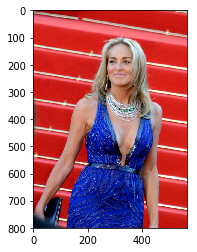

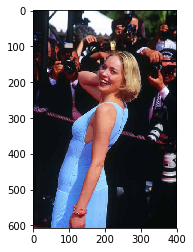

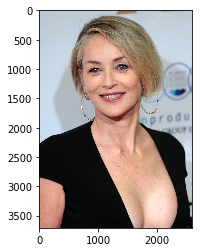

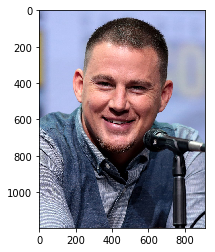

In [25]:
# define filenames
filenames = ['sharon_stone1.jpg', 'sharon_stone2.jpg',
    'sharon_stone3.jpg', 'channing_tatum.jpg']

# show images
for filename in filenames:
    pyplot.figure()
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pyplot.imshow(image)

In [26]:
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define sharon stone
sharon_id = embeddings[0]
# verify known photos of sharon
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('Negative Tests')
is_match(embeddings[0], embeddings[3])

Positive Tests
>face is a Match (0.418 <= 0.500)
>face is a Match (0.295 <= 0.500)
Negative Tests
>face is NOT a Match (0.709 > 0.500)
